# Sampling

In [ ]:
import numpy as np
import pandas as pd
from utils import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

def random_index(x=5, N=252):
    a = (np.random.random_sample(x)*N).astype(int)
    while x!=len(set(a)):
        a = np.append(a,int(np.random.random_sample()*N))
    return a  # maybe use np.random.sample()

def uni_index(x=5,N=252):
    a = np.linspace(0,N-1,x).astype(int)
    return a

def eigval_index(x=5, N=252):
    return np.arange(x)

100%|██████████| 8/8 [02:41<00:00, 20.22s/it]


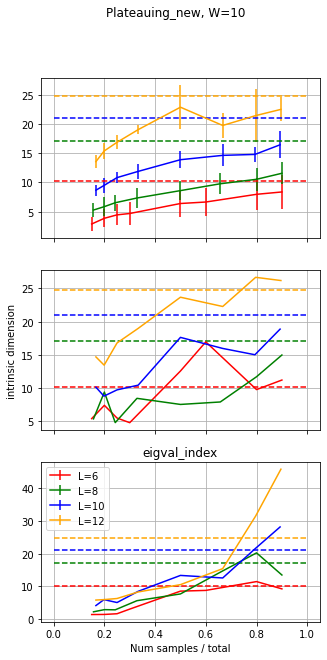

In [98]:

Ls, W, seed = [6,8,10,12], 10, 1
ruuns = [200,100,20,5]
sample_methods = [random_index, uni_index, eigval_index]
colors = 'red, green, blue, orange'.split(', ')

fig, ax = plt.subplots(3,1, figsize=(5,10), sharex=True)

for L, runs, color in zip(Ls,ruuns, colors):
    N = binomial(L)
    samples = [N//6,N//5,N//4,N//3,N//2, N//3*2, N//5*4, N//10*9]
    data_dict = {}

    vals, vecs = np.linalg.eigh(constructHamiltonian(L,W=W, seed=seed, periodic_boundary_conditon=True))

    data_dict['All samples'] = nn2(vecs)[0]

    for sample_method in sample_methods:
        data_dict[sample_method] = {}
        for i in tqdm(samples):
            data_dict[sample_method][i] = []

            if sample_method == sample_methods[0]:
                for j in range(runs):
                    sample_index = sample_method(i, N)
                    #print(sample_index)
                    vecs_sample = vecs[:,sample_index]
                    data_dict[sample_method][i].append(nn2(vecs_sample)[0])
            else:
                sample_index = sample_method(i, N)
                #print(sample_index)
                vecs_sample = vecs[:,sample_index]
                data_dict[sample_method][i].append(nn2(vecs_sample)[0])
    #print(data_dict)

    

    for index, s in enumerate(sample_methods):

        x = np.array(list(data_dict[s].keys()))/N
        y = [np.mean(data_dict[s][X]) for X in data_dict[s].keys()]
        yerr = [np.std(data_dict[s][X]) for X in data_dict[s].keys()]
        #print(x, y, yerr)

        ax[index].errorbar(x,y,yerr, label='L={}'.format(L), color=color)
        ax[index].plot([0,1],[data_dict['All samples'],data_dict['All samples']],ls='--',c=color)
        ax[index].title(str(s).split()[1])
        data = np.vstack([x,y,yerr])
        np.savez('data/plateau/L{}_W{}_{}.npz'.format(L,W,s),data)

plt.xlabel('Num samples / total')
ax[1].set_ylabel('intrinsic dimension')

fig.suptitle('Plateauing_new, W={}'.format(W))
plt.legend()
[ax[i].grid() for i in range(3)]
plt.show()



In [94]:
str(s).split(' ')[1]

'eigval_index'

## lets load up those results

In [22]:
sample_method = 'random_index'
Ls, W, seed = [6,8,10,12,14], 10, 1
data_dict = {}
for L in Ls:
    a = np.load('data/plateau/L{}_W{}_{}.npz'.format(L,10,sample_method))
    b = a[a.files[0]]
    data_dict[L] = {'x' :b[0],
                    'y' : b[1],
                    'yerr' : b[2]}

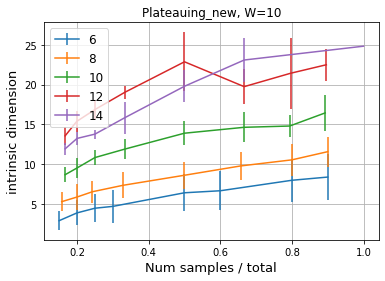

In [23]:
plt.figure()

[plt.errorbar(x = data_dict[d]['x'],
                y= data_dict[d]['y'],
                yerr=data_dict[d]['yerr'],
                label=d
                ) for d in data_dict]


plt.xlabel('Proportion of samples', fontsize=13)
plt.ylabel('Intrinsic dimension', fontsize=13)
plt.title('Plateauing ID with random sampled eigenstates'.format(W), fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()

In [26]:
N = 100
[N//6,N//5,N//4,N//3,N//2, N//3*2, N//5*4, N//10*9]

[16, 20, 25, 33, 50, 66, 80, 90]

# New

In [37]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, np.sqrt(variance)

In [105]:
# Params
Ls, W, seed = [12,14], 10, 42
runs_lst = [20,5]
sample_method = random_index


In [106]:
data_dict = {}
data_dict['params'] = dict(zip(Ls, runs_lst))
data_dict['params']['W'] = W
data_dict['params']['seed'] = seed

    
for L, runs in zip(Ls, runs_lst):
    data_dict[L] = {}
    N = binomial(L)
    spacing = np.linspace(0.15,.9,12)
    num_samples_lst = (spacing*N).astype(int)
    inner_data_dict = {}

    vals, vecs = np.linalg.eigh(constructHamiltonian(L=L, W=W, seed=seed, periodic_boundary_conditon=True))
    data_dict[L][1.0] = {'id':nn2(vecs)[0], 'std':0}

    for num_samples in tqdm(num_samples_lst):
        tmp_id, tmp_q = [], []
        for run in range(runs):
            sample_index = sample_method(num_samples, N)
            vecs_sample = vecs[:,sample_index]
            d, q = nn2(vecs_sample)
            tmp_id.append(d)
            tmp_q.append(q)

        mean_id, std = weighted_avg_and_std(tmp_id, tmp_q)
        data_dict[L][round(num_samples/N,3)] = {'id':mean_id, 'std':std}

  8%|▊         | 1/12 [51:04<9:21:47, 3064.31s/it]


KeyboardInterrupt: 

In [122]:
Ls = [6,8,10,12]
np.savez('plateauing_dict_{}-{}.npz'.format(min(Ls), max(Ls)),data_dict1)

6
8
10
12


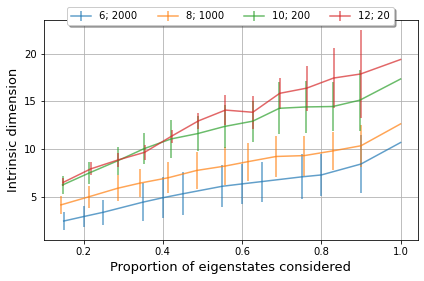

In [125]:
file = np.load('plateauing_dict_6-12.npz', allow_pickle=True)
data_dict = file[file.files[0]].item()


plt.figure(figsize=(6,4),tight_layout=True)
#colors = sns.color_palette('pastel')

for L in Ls:
    if L != 'params':
        print(L)
        x = sorted(data_dict[L].keys())
        y = [data_dict[L][i]['id'] for i in x]
        yerr = [data_dict[L][i]['std'] for i in x]
        plt.errorbar(x,y,yerr=yerr, alpha=.7, label=f"{L}; {data_dict['params'][L]}")

plt.xlabel('Proportion of eigenstates considered', fontsize=13)
plt.ylabel('Intrinsic dimension', fontsize=13)

#plt.title('Plateauing_new, W={}'.format(data_dict['params']['W']), fontsize=16)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
          ncol=4, fancybox=True, shadow=True)
plt.grid()
plt.show()


{12: 20, 14: 5, 'W': 10, 'seed': 42}